In [1]:
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
from numpy import eye, array, asarray, exp
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float': '{: 6.4f}'.format})
from math import sqrt

#%matplotlib inline
import matplotlib
import matplotlib.cm as cm
from matplotlib import animation
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
rcParams["font.serif"] = "cmr14"
rcParams['savefig.dpi'] = 300
rcParams["figure.dpi"] = 100
rcParams.update({'font.size': 18})
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

try: 
    import serial
except:
    !pip3 install pyserial
    import serial

import time, csv, os, requests
plt.rcParams["figure.figsize"] = (8,5)
 
import struct

def Serial_write(U):
    buf = struct.pack('%sf' % len(U), *U)
    ser.write(bytearray(b' ')+bytearray(b'!')+buf)
    
def clamp(x, lowerlimit, upperlimit): 
    if (x < lowerlimit):
        return lowerlimit
    elif (x > upperlimit):
        return upperlimit
    return x

def smootherstep(edge0, edge1, x): 
    # Scale, and clamp x to 0..1 range
    x = clamp((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    # Evaluate polynomial
    return x * x * x * (x * (x * 6 - 15) + 10)

import copy

In [10]:
port = '/dev/cu.usbserial-1110'
ser = serial.Serial(port,baudrate=115200,timeout=0.1)
ser.flushInput()
ser.write(bytearray(b'R'))
time.sleep(10)

In [11]:
ser.close()
ser = serial.Serial(port,baudrate=115200,timeout=0.1)
ser.flushInput()

el_time = []; mtheta = []
gyro = []; U_esp = []
U_sent = []; U_here = []
DEG2RAD = np.pi/180.

Nfloats = 5
Fs = 50
y_theta = 0
y_gyro = 0
Tf = 15
Ulim = 600

Kp = 400 #
Kd = 1.5/5*Kp * DEG2RAD

T_ramp = 0.25 # time for ramp in seconds
edge0 = 3
edge01 = edge0 + T_ramp         

U = np.zeros(Nfloats) # make something up
uu = U
Serial_write(U)

t_start = time.time()
current_time = 0
prev_time = 0
t_print = 0
Ref = 0
ser.flushInput()
while(current_time <= Tf):
    current_time = time.time() - t_start
    if (current_time > edge0):
        Ref = 60.*DEG2RAD*smootherstep(edge0,edge01,current_time);

    if (current_time >= prev_time + 1/Fs/2):
        try:
            decoded_bytes = ser.readline().decode('ascii').split(',')
            uu = [float(value) for value in decoded_bytes]
            el_time.append(current_time)

            y_theta = copy.copy(uu[1])
            y_gyro = copy.copy(uu[2])

            mtheta.append(57.3*y_theta)
            gyro.append(uu[2])
            U_esp.append(uu[3])
            U_sent.append(uu[4])

            u_inp = Kp*(Ref - y_theta) - Kd*y_gyro 
            u_inp = clamp(u_inp,-Ulim,Ulim)
            # sign change in the system
            U = -u_inp*np.ones(Nfloats) # make something up
            U_here.append(u_inp)
        except:
            pass

        Serial_write(U)

        if current_time >= t_print + 1:
            print(f'{(current_time)/Tf:.2f}',end=' ')
            t_print = copy.copy(current_time)

        prev_time = current_time
        
U = np.zeros(Nfloats) # make something up
Serial_write(U)
ser.close()

0.07 0.13 0.20 0.27 0.34 0.40 0.47 0.54 0.60 0.67 0.74 0.80 0.87 0.94 

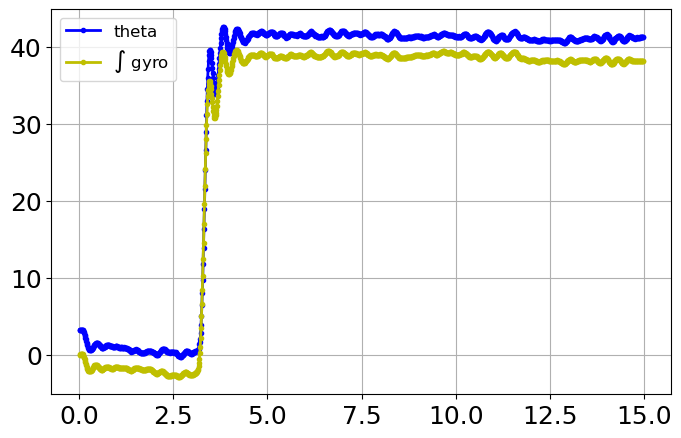

In [12]:
# parts to plot
lg = len(gyro)-2
dt = np.diff(el_time);
ang_GyrY = np.cumsum(gyro[:lg]*dt[:lg])
II = slice(0, lg, 1)

l = min(len(el_time),min(len(mtheta),len(gyro)))
fig, ax = plt.subplots()
ax.plot(el_time[II],mtheta[II],'b.-',label='theta')
ax.plot(el_time[II],ang_GyrY[II],'y.-',label=r'$\int$ gyro')
plt.legend()
plt.show()

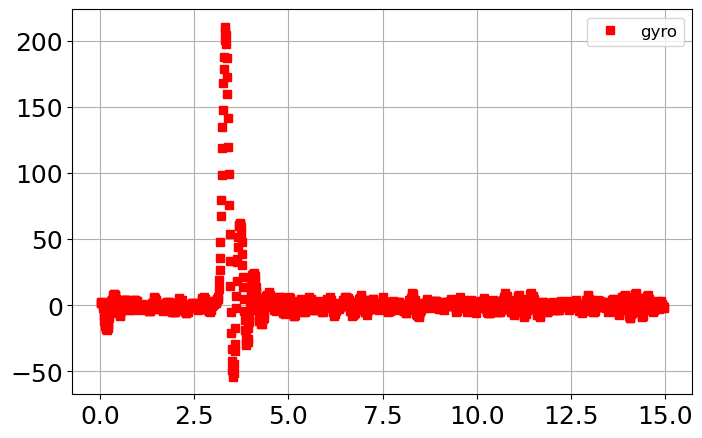

In [13]:
l = min(len(mtheta),len(gyro))
fig, ax = plt.subplots()
#ax.plot(mtheta[II],'b-',label='theta')
ax.step(el_time[II],np.array(gyro[II]),'rs',label='gyro')
plt.legend()
plt.show()

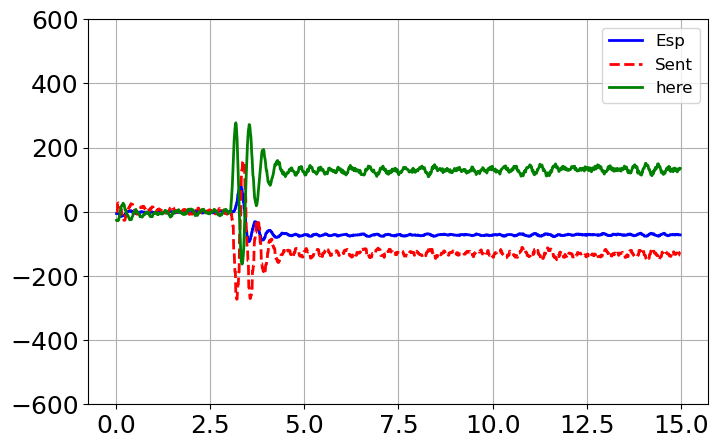

In [16]:
fig, ax = plt.subplots()
ax.plot(el_time[II],U_esp[II],'b-',label='Esp')
#CC = [1*x for x in U_sent]
ax.plot(el_time[II],U_sent[II],'r--',label='Sent')
ax.plot(el_time[II],U_here[II],'g-',label='here')
plt.legend()
plt.ylim([-Ulim, Ulim])
plt.show()

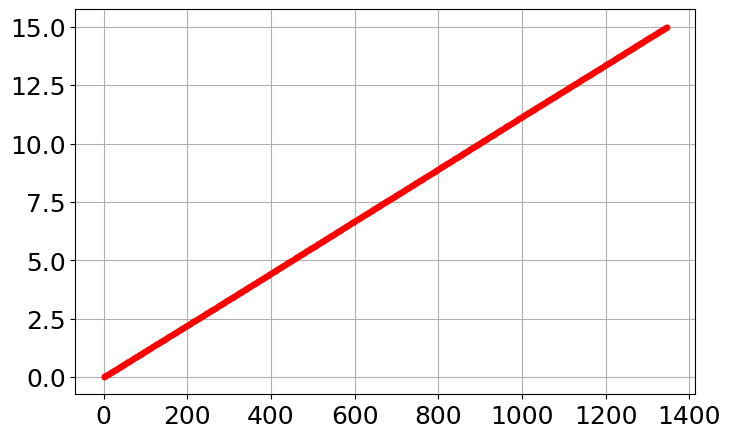

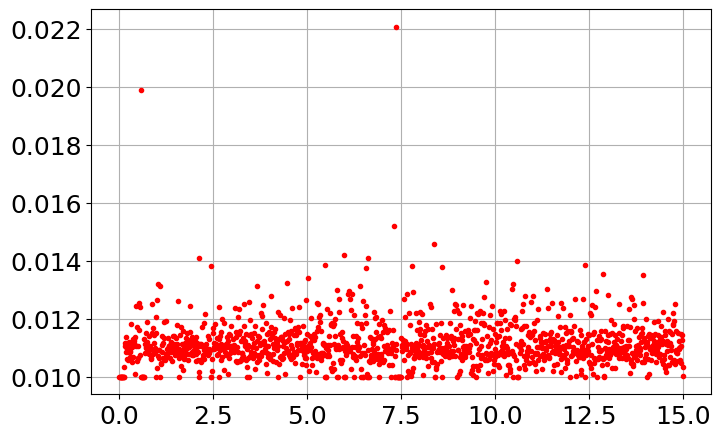

In [15]:
fig, ax = plt.subplots()
#ax.plot(el_time[:-1],np.diff(el_time),'r.',label='gyro')
ax.plot(el_time,'r.',label='gyro')
#ax.set_xlim([0, 200])
plt.show()

fig, ax = plt.subplots()
ax.plot(el_time[:-1],np.diff(el_time),'r.',label='gyro')
#ax.set_xlim([0, 200])
plt.show()

In [ ]:
np.histogram(np.diff(el_time))